# Import All Neccessary Library

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve


# Import Dataset

In [12]:
dataset_BurnoutLevel = "C:/Users/Jia Xuan/Downloads/fyp-linked-github/fyp_Degree/synthetic-employee-dataset.json"

df2 = pd.read_json(dataset_BurnoutLevel)

In [ ]:
useless_cols = ['employee_id','department', 'role','job_level','tenure_months','salary',
                'workload_score','team_sentiment','recent_feedback', 'performance_score',
                'communication_patterns', 'training_participation','collaboration_score',
                'technical_skills', 'soft_skills', 'email_sentiment','slack_activity','meeting_participation',
                'turnover_reason', 'risk_factors_summary','turnover_probability_generated',
                'risk_factors_summary', 'persona_name','role_complexity_score','career_progression_score','left_company']

df2 = df2.drop(columns=useless_cols)

# Data Understanding

In [14]:
numerical_cols = df2.select_dtypes(include=np.number).columns
categorical_cols = df2.select_dtypes(include=["object", "bool"]).columns

## Dataset Overview

In [ ]:
df2.head()

,satisfaction_score,project_completion_rate,overtime_hours,goal_achievement_rate,stress_level,burnout_risk
0,0.623746,0.524187,0.00000,0.632482,0.908992,0.866643
1,0.982556,0.558206,0.00000,0.538587,0.363321,0.218996
2,0.767200,0.566849,0.00000,0.624656,0.664378,0.541531
3,0.185888,0.767456,9.59168,0.959320,1.000000,1.000000
4,0.566706,0.597235,0.00000,0.677305,0.723049,0.614825


## Dataset Structure Description

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849999 entries, 0 to 849998
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   satisfaction_score       849999 non-null  float64
 1   project_completion_rate  849999 non-null  float64
 2   overtime_hours           849999 non-null  float64
 3   goal_achievement_rate    849999 non-null  float64
 4   stress_level             849999 non-null  float64
 5   burnout_risk             849999 non-null  float64
dtypes: float64(6)
memory usage: 38.9 MB


## Summary Statistics

In [17]:
df2.describe()

,satisfaction_score,project_completion_rate,overtime_hours,goal_achievement_rate,stress_level,burnout_risk
count,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000
mean,0.581941,0.595412,3.132903,0.692027,0.791048,0.735941
std,0.276268,0.161173,6.094207,0.183911,0.264536,0.315756
min,0.050000,0.059290,0.000000,0.074113,0.000000,0.000000
25%,0.367016,0.490179,0.000000,0.571340,0.613005,0.479950
50%,0.583188,0.609499,0.000000,0.699235,0.942151,0.914494
75%,0.813912,0.716149,4.161240,0.825585,1.000000,1.000000
max,1.000000,1.000000,73.953574,1.000000,1.000000,1.000000


## Distribution Analysis for Numerical Features

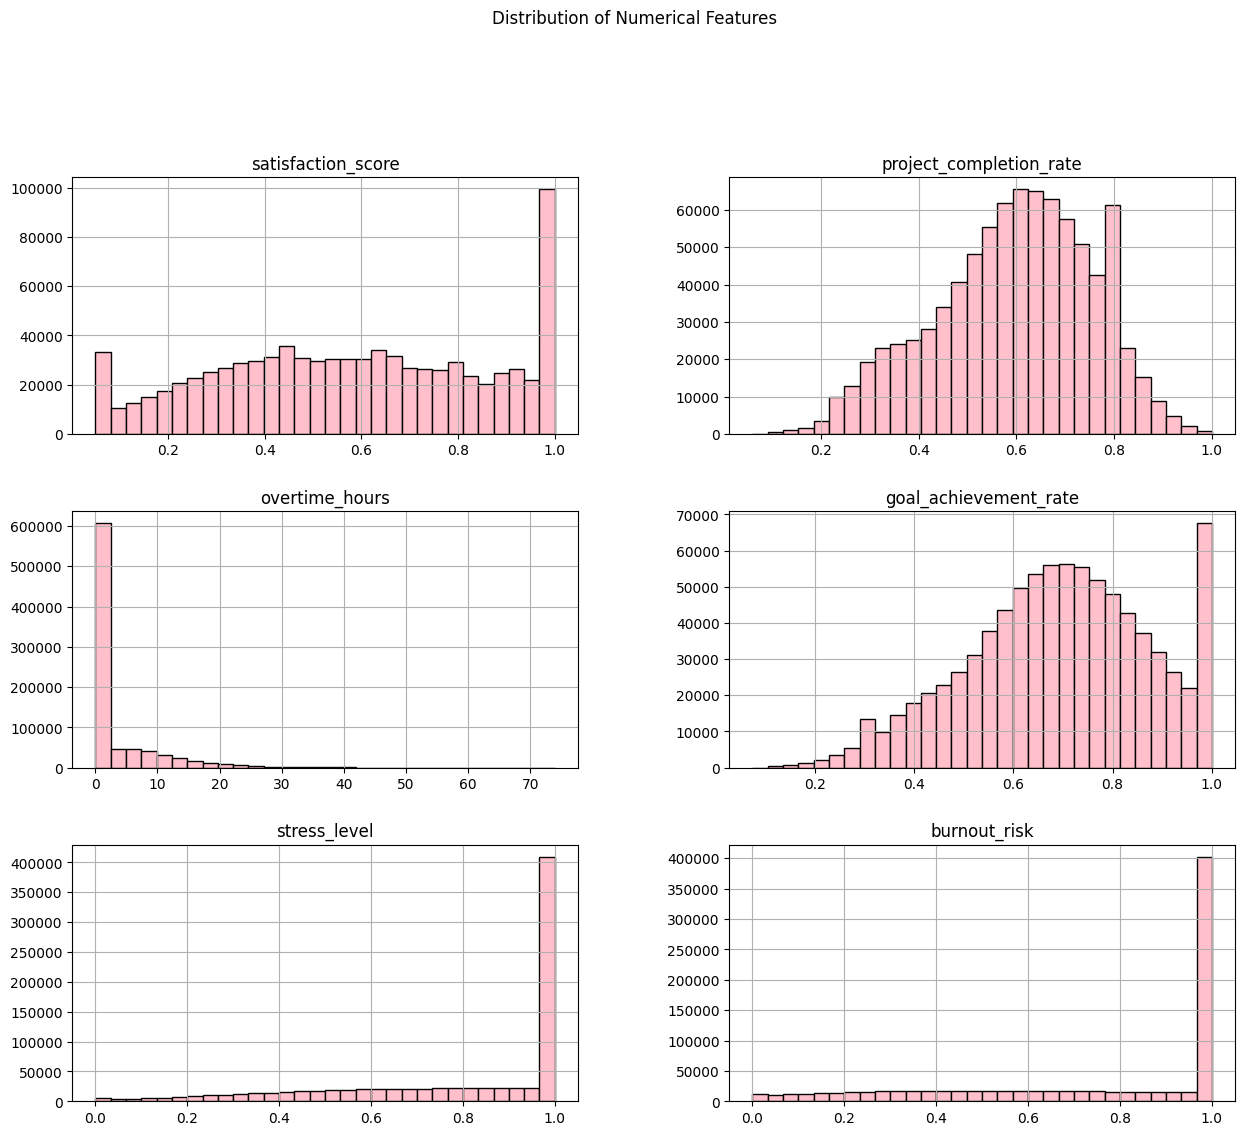

In [18]:
df2[numerical_cols].hist(
    figsize=(15, 12),
    bins=30,
    color='pink',
    edgecolor='black'
)

plt.suptitle("Distribution of Numerical Features", y=1.02)
plt.show()


## Corelation Analysis

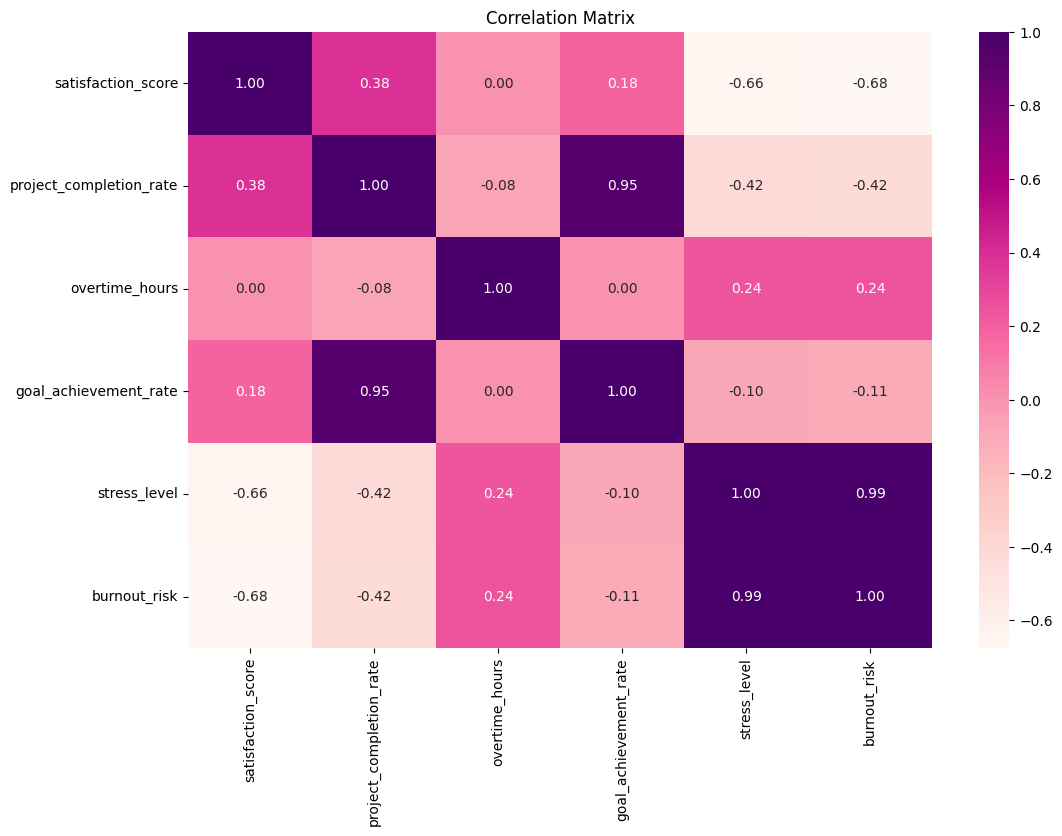

In [19]:
corr = df2[numerical_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdPu")
plt.title("Correlation Matrix")
plt.show()

## Data Quality Analysis

### Missing Value Analysis

In [20]:
df2.isnull().sum()

satisfaction_score         0
project_completion_rate    0
overtime_hours             0
goal_achievement_rate      0
stress_level               0
burnout_risk               0
dtype: int64

### Outlier Analysis

In [21]:
numerical_cols = df2.select_dtypes(include=np.number).columns

outlier_count = []

for col in numerical_cols:
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    count = ((df2[col] < lower) | (df2[col] > upper)).sum()
    
    outlier_count.append({
        "Column": col,
        "Number_of_Outliers": count
    })

iqr_outlier_df2 = pd.DataFrame(outlier_count)

iqr_outlier_df2.sort_values("Number_of_Outliers", ascending=False)


,Column,Number_of_Outliers
2,overtime_hours,102532
4,stress_level,4939
3,goal_achievement_rate,2048
1,project_completion_rate,1756
0,satisfaction_score,0
5,burnout_risk,0


### Duplicate Data Analysis

In [22]:
duplicate_rows = df2.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicate_rows}")

Number of Duplicate Rows: 747


# Data Preprocessing

## Drop duplicate rows

In [23]:
# Keep first occurrence (default)
df2 = df2.drop_duplicates(keep='first')

# Keep last occurrence
df2 = df2.drop_duplicates(keep='last')

## Outlier Handling

In [24]:
# --- Outliers BEFORE cleaning ---
Q1 = df2[numerical_cols].quantile(0.25)
Q3 = df2[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers_before = ((df2[numerical_cols] < lower) | (df2[numerical_cols] > upper)).sum()

# --- Clip the outliers (IQR method) ---
for col in numerical_cols:
    df2[col] = np.clip(df2[col], lower[col], upper[col])

# --- Outliers AFTER cleaning ---
outliers_after = ((df2[numerical_cols] < lower) | (df2[numerical_cols] > upper)).sum()

# --- Comparison table ---
outlier_comparison = pd.DataFrame({
    'Before': outliers_before,
    'After': outliers_after
})

outlier_comparison


,Before,After
satisfaction_score,0,0
project_completion_rate,1760,0
overtime_hours,102210,0
goal_achievement_rate,2058,0
stress_level,4865,0
burnout_risk,0,0


In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 849252 entries, 0 to 849998
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   satisfaction_score       849252 non-null  float64
 1   project_completion_rate  849252 non-null  float64
 2   overtime_hours           849252 non-null  float64
 3   goal_achievement_rate    849252 non-null  float64
 4   stress_level             849252 non-null  float64
 5   burnout_risk             849252 non-null  float64
dtypes: float64(6)
memory usage: 45.4 MB


# Target Analysis

In [26]:
# Create a new column for Classification
def create_risk_category(score):
    if score < 0.4: return 'Low'
    elif score < 0.7: return 'Medium'
    else: return 'High'

df2['risk_label'] = df2['burnout_risk'].apply(create_risk_category)



print("Burnout Risk Distribution:")
print(df2['risk_label'].value_counts())
print(f"\nPercentage Distribution:")
print(df2['risk_label'].value_counts(normalize=True) * 100)

Burnout Risk Distribution:
risk_label
High      524935
Low       171065
Medium    153252
Name: count, dtype: int64

Percentage Distribution:
risk_label
High      61.811453
Low       20.143020
Medium    18.045527
Name: proportion, dtype: float64


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# 1. Define X and y
# Drop 'burnout_risk' (the numeric score) to avoid leakage
X = df2.drop(columns=['risk_label', 'burnout_risk','stress_level'])
y = df2['risk_label']

# 2. Initialize the Downsampler
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)

# 3. Apply to the data
X_balanced, y_balanced = rus.fit_resample(X, y)

print(f"Balanced Dataset Distribution: {Counter(y_balanced)}")

Balanced Dataset Distribution: Counter({'High': 153252, 'Low': 153252, 'Medium': 153252})


# Models to predict BurnOut Risk Level

## Label Encoding

In [30]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_balanced)

## Train Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## Baseline Classification Models

In [35]:
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, objective='multi:softprob',
                             num_class=3, random_state=42) }

# Train and print baseline accuracy
for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Logistic Regression Accuracy: 0.9766
Decision Tree Accuracy: 0.8096
Random Forest Accuracy: 0.8621
XGBoost Accuracy: 0.9738


## Hyperparameter Tuning Model

In [44]:
# Define the parameter grids
from sklearn.model_selection import StratifiedKFold


param_grids = {
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "solver": ['saga'] # Faster for large datasets
    },
    "Decision Tree": {
        "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 10, 20]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20],
        "min_samples_leaf": [1, 4]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0]
    }
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_estimators = {}

# Loop through models and tune
for name, grid in param_grids.items():
    print(f"Tuning {name}...")
    
    # Initialize base model
    if name == "Logistic Regression":
        model = LogisticRegression(max_iter=500)
    elif name == "Decision Tree":
        model = DecisionTreeClassifier()
    elif name == "Random Forest":
        model = RandomForestClassifier(n_jobs=-1)
    else: # XGBoost
        model = XGBClassifier(objective='multi:softprob', num_class=3)

    # Run Randomized Search
    rs = RandomizedSearchCV(
        model, 
        param_distributions=grid, 
        n_iter=5, # Number of random combinations to try
        cv=skf, 
        scoring='accuracy', 
        random_state=42, 
        n_jobs=-1
    )
    
    rs.fit(X_train, y_train)
    best_estimators[name] = rs.best_estimator_
    print(f"Best params for {name}: {rs.best_params_}\n")

Tuning Logistic Regression...


c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best params for Logistic Regression: {'solver': 'saga', 'C': 10}

Tuning Decision Tree...
Best params for Decision Tree: {'min_samples_split': 2, 'max_depth': None}

Tuning Random Forest...
Best params for Random Forest: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': 20}

Tuning XGBoost...
Best params for XGBoost: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2}



## Final Evaluation

In [46]:
# Create a list to store comparison data
comparison_data = []

for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    comparison_data.append({"Model": name, "Tuned Accuracy": acc})

# Convert to DataFrame for a clean table
df_comparison = pd.DataFrame(comparison_data).sort_values(by="Tuned Accuracy", ascending=False)
print("===== Model Comparison Table =====")
print(df_comparison)

===== Model Comparison Table =====
                 Model  Tuned Accuracy
3              XGBoost        0.990593
0  Logistic Regression        0.989810
2        Random Forest        0.987700
1        Decision Tree        0.983513


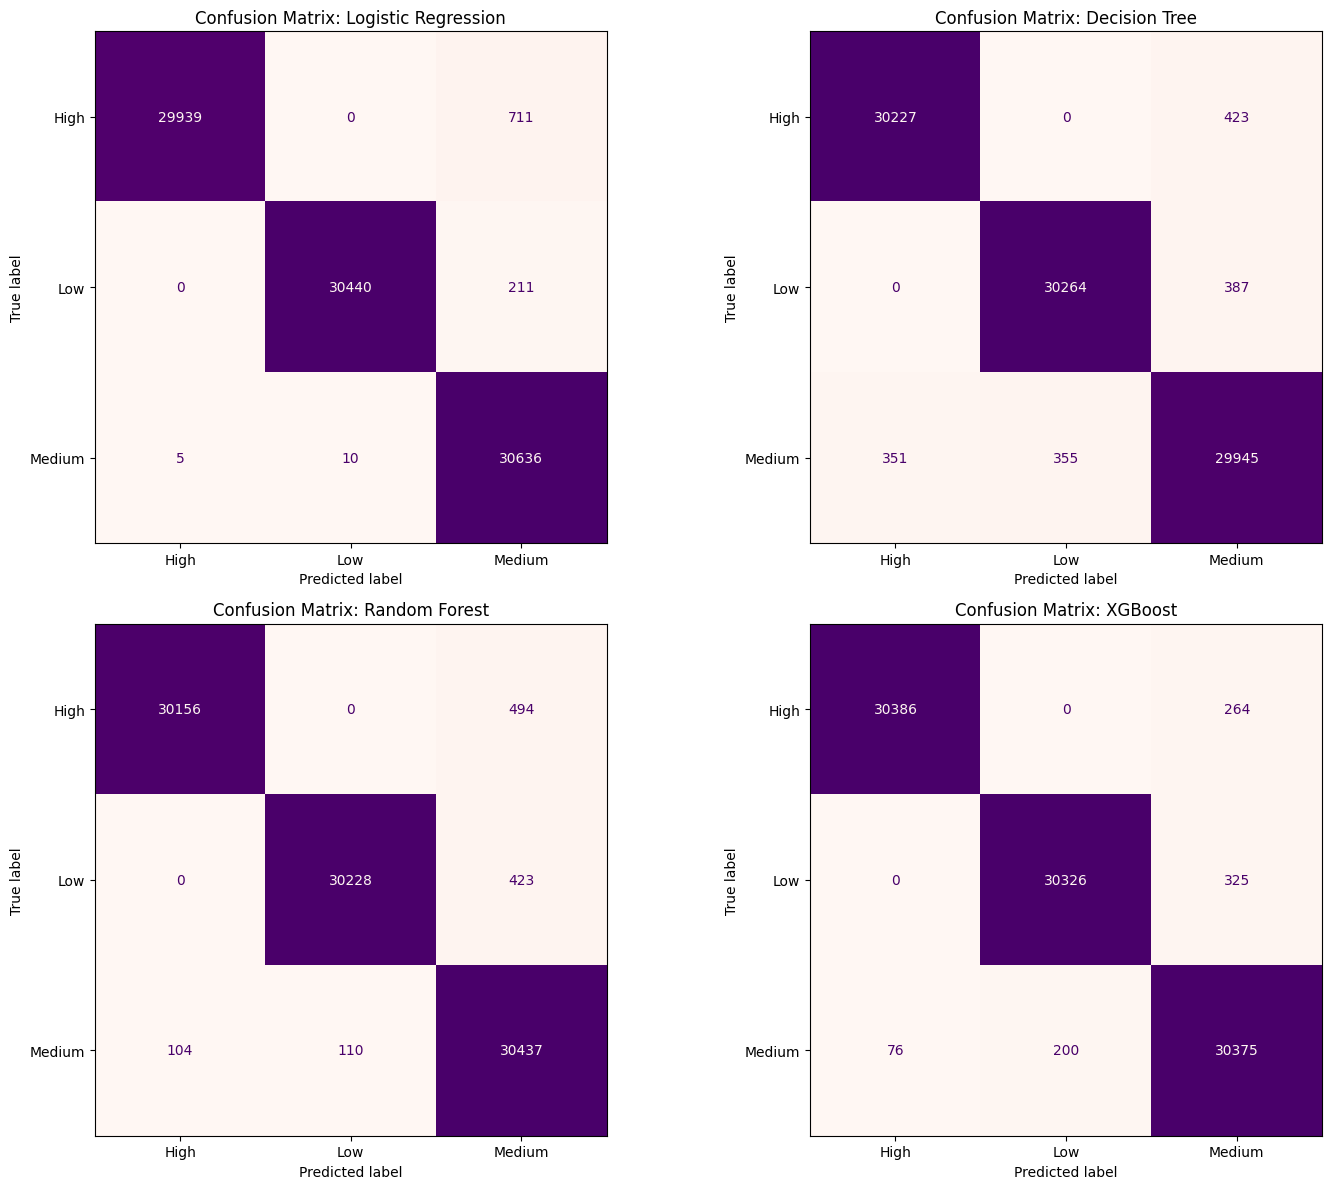

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(best_estimators.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='RdPu', values_format = 'd', ax=axes[i], colorbar=False)
    axes[i].set_title(f"Confusion Matrix: {name}")

plt.tight_layout()
plt.show()

c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
6 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Jia Xuan\miniconda3\envs\FYP\lib\site-packages\sklearn\linear_model\_logistic.py", line 1335, in fit
    raise Valu

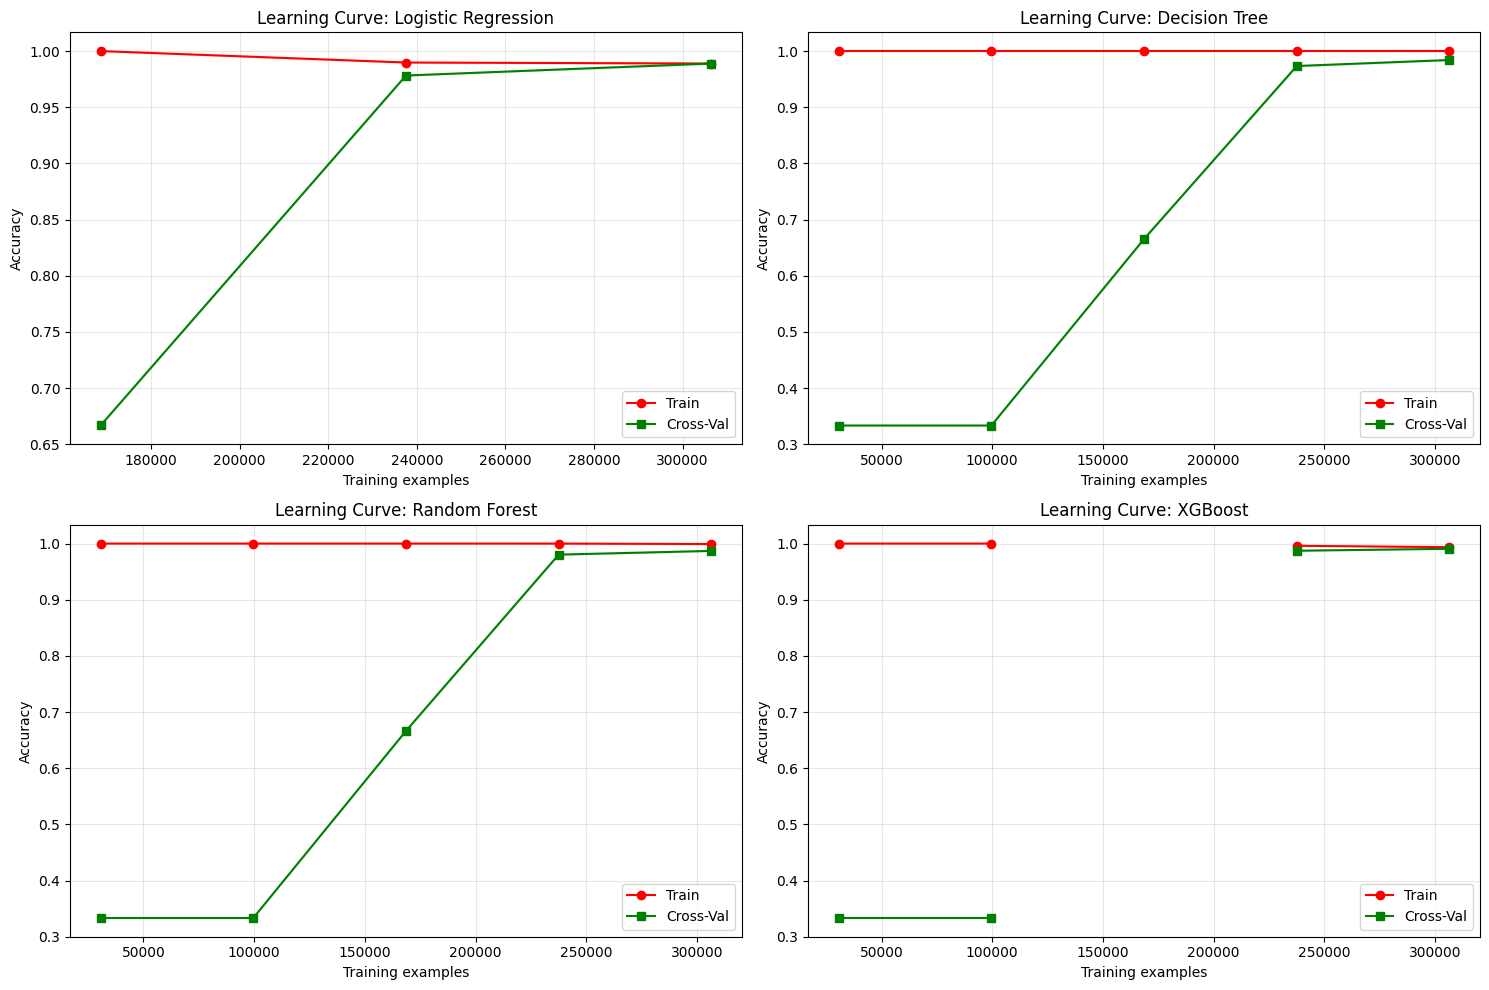

In [48]:
plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(best_estimators.items()):
    plt.subplot(2, 2, i+1)
    
    # Use stratified cross-validation for learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, 
        X_balanced, 
        y_encoded, 
        cv=skf,
        n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5),
        random_state=42
    )
    
    # Calculate mean and standard deviation
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train")
    plt.plot(train_sizes, test_scores_mean, 's-', color="g", label="Cross-Val")
    
    # Add shaded area for standard deviation (optional)
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Example comparing max_depth impact across the tree-based models
from sklearn.model_selection import validation_curve


models_to_compare = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}
param_range = [5, 10, 15, 20]

for name, model in models_to_compare.items():
    train_v, test_v = validation_curve(
        model, X_balanced, y_encoded, param_name="max_depth", 
        param_range=param_range, cv=3, scoring="accuracy", n_jobs=-1
    )
    plt.figure(figsize=(8, 4))
    plt.plot(param_range, np.mean(train_v, axis=1), label="Train")
    plt.plot(param_range, np.mean(test_v, axis=1), label="Cross-Val")
    plt.title(f"Validation Curve ({name}): max_depth")
    plt.legend()
    plt.show()

In [ ]:
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, roc_curve


plt.figure(figsize=(10, 8))

for name, model in best_estimators.items():
    y_prob = model.predict_proba(X_test)
    # Using macro-average for multi-class ROC
    fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=[0,1,2]).ravel(), y_prob.ravel())
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Comparison of ROC Curves (All Models)")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

comparison_list = []

for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    comparison_list.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4)
    })

# Create and display the table
df_results = pd.DataFrame(comparison_list).sort_values(by="Accuracy", ascending=False)
print("===== FINAL MODEL PERFORMANCE COMPARISON =====")
display(df_results)